In [2]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)


d:\ads_test


In [3]:
from libs.lib import *
print(tf.__version__)

2.13.0


In [4]:
exps_dir = "../../../exps"
# exps_dir = sys.argv[3]
# if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
#   os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [5]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        print(f'{scaler}: {type}')
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

Standard_Label: basic
(656, 42) (656, 2) (324, 42) (324, 2)
Standard_Label: class_dict_weight
(656, 42) (656, 2) (324, 42) (324, 2)
Standard_Label: Oversampling
(1001, 42) (1001, 2) (324, 42) (324, 2)
Standard_Label: SMOTE
(656, 42) (656, 2) (324, 42) (324, 2)
Standard_Label: Undersampling
(355, 42) (355, 2) (324, 42) (324, 2)
MinMax_Label: basic
(656, 42) (656, 2) (324, 42) (324, 2)
MinMax_Label: class_dict_weight
(656, 42) (656, 2) (324, 42) (324, 2)
MinMax_Label: Oversampling
(1001, 42) (1001, 2) (324, 42) (324, 2)
MinMax_Label: SMOTE
(1002, 42) (1002, 2) (324, 42) (324, 2)
MinMax_Label: Undersampling
(355, 42) (355, 2) (324, 42) (324, 2)
10


In [6]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)

In [8]:
x_test.shape

(330, 42)

In [9]:
x_train.shape

(1022, 42)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform



#### * Xây dựng model:

In [11]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#y_train

In [12]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    y_pred = tf.round(y_pred)
    f1 = f1_score(y_true, y_pred, average='micro')
    return 1 - f1

In [13]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [14]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [16]:
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=10)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [19]:
from tabnet_keras import TabNetRegressor, TabNetClassifier
from tensorflow.keras.optimizers import Adam

tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



### Classification
model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(0.01))
model.fit(x_train, y_train_onehot, epochs = 100, batch_size = 1024)

Epoch 1/100


1/1 [==============================] - 44s 44s/step - loss: 0.8514
Epoch 2/100
1/1 [==============================] - 0s 38ms/step - loss: 0.6704
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.5892
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.5332
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 0.4862
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 0.4504
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 0.4226
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 0.3868
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 0.3652
Epoch 10/100
1/1 [==============================] - 0s 34ms/step - loss: 0.3348
Epoch 11/100
1/1 [==============================] - 0s 33ms/step - loss: 0.3138
Epoch 12/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2848
Epoch 13/100
1/1 [==============================] - 0s 35ms/s

In [31]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(42,1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.001
input_shape =(42,1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.001
kernel_size =3
filter_size=64

# Block 1
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

x = GlobalAveragePooling1D()(x)
# x = GlobalMaxPooling1D()(x)
x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification

model = Model(x_input, x, name='vgg16')
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_9cat_loss, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=50,
    min_lr=0.000001,
    verbose=1,
)


In [32]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 42, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 42, 64)            256       
                                                                 
 block1_conv2 (Conv1D)       (None, 42, 64)            12352     
                                                                 
 block1_pool (MaxPooling1D)  (None, 21, 64)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 21, 128)           24704     
                                                                 
 block2_conv2 (Conv1D)       (None, 21, 128)           49280     
                                                                 
 block2_pool (MaxPooling1D)  (None, 10, 128)           0     

In [33]:
#Set data order
data_order = 5

In [34]:
dict_data[data_order][1].shape

(656, 2)

In [35]:
model.fit(x=dict_data[data_order][0],y=dict_data[data_order][1],
          validation_data=(dict_data[data_order][2],dict_data[data_order][3]),
          batch_size=64,epochs= 1200, callbacks=[early_stopping,lr_scheduler])

Epoch 1/1200


11/11 [==============================] - 3s 145ms/step - loss: 0.7816 - accuracy: 0.7119 - val_loss: 0.6431 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 2/1200
11/11 [==============================] - 1s 58ms/step - loss: 0.5828 - accuracy: 0.7637 - val_loss: 0.5778 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 3/1200
11/11 [==============================] - 1s 55ms/step - loss: 0.5528 - accuracy: 0.7637 - val_loss: 0.5850 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 4/1200
11/11 [==============================] - 1s 57ms/step - loss: 0.5490 - accuracy: 0.7637 - val_loss: 0.5755 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 5/1200
11/11 [==============================] - 1s 62ms/step - loss: 0.5491 - accuracy: 0.7637 - val_loss: 0.5782 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 6/1200
11/11 [==============================] - 1s 63ms/step - loss: 0.5467 - accuracy: 0.7637 - val_loss: 0.5775 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 7/1200
11/11 [==============================] - 1s 63ms/step - loss: 0

KeyboardInterrupt: 

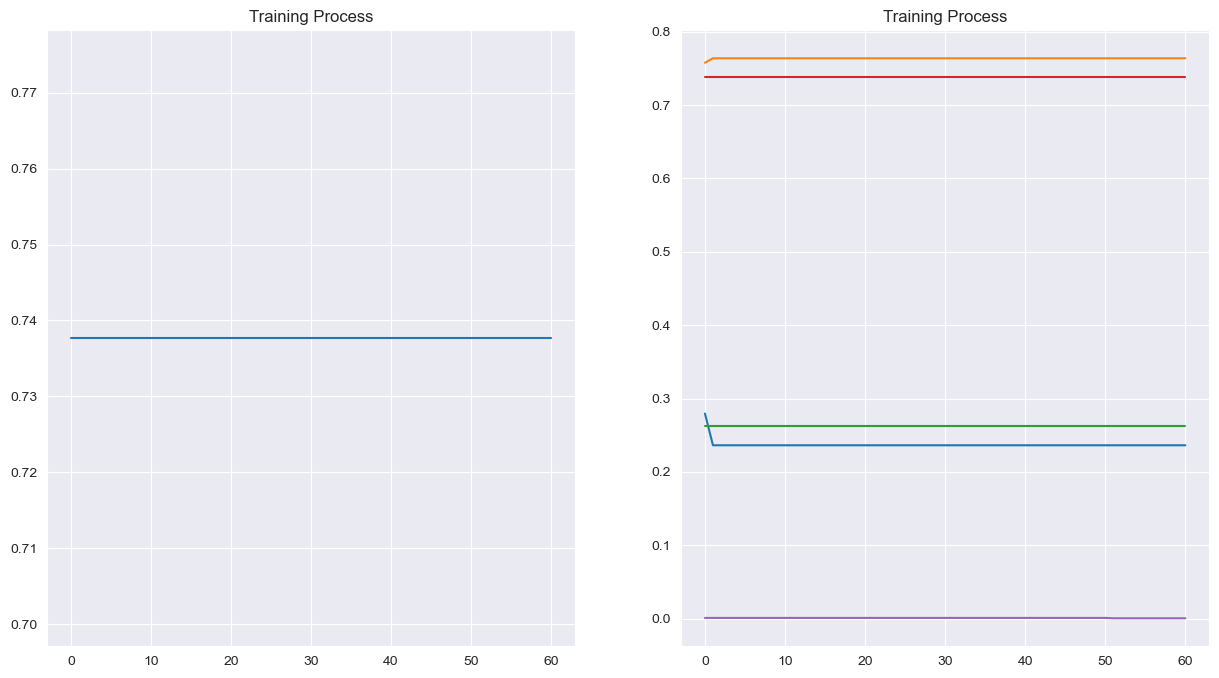

<Figure size 640x480 with 0 Axes>

In [ ]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [ ]:
predictions = model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 0s 7ms/step


0.7376543209876543

In [ ]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7376543209876543
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        85
           0       0.74      1.00      0.85       239

    accuracy                           0.74       324
   macro avg       0.37      0.50      0.42       324
weighted avg       0.54      0.74      0.63       324



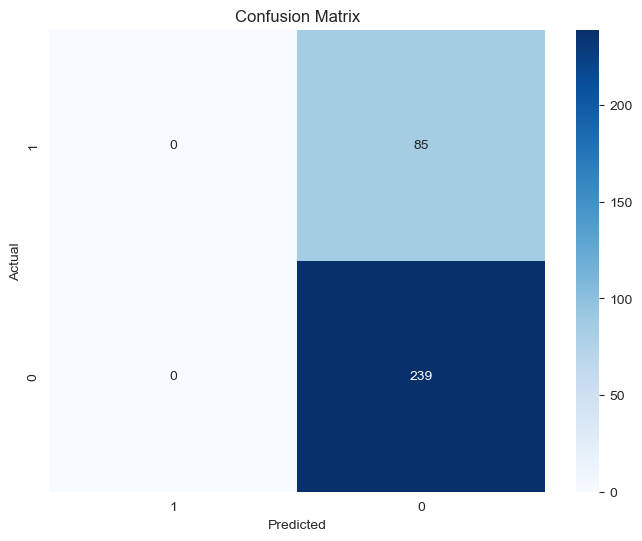

In [ ]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

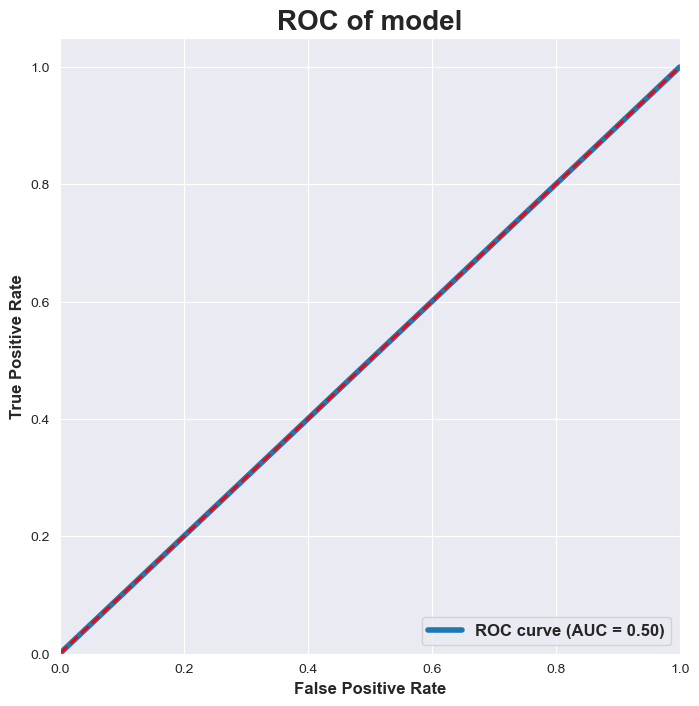

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [ ]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [ ]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------


In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 239 chiếm khoảng 73.76543209876543% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 0 chiếm khoảng 0.0% so với thực tế
